Loaded 'insurance.csv' locally.

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
5   31  female  25.740         0     no 

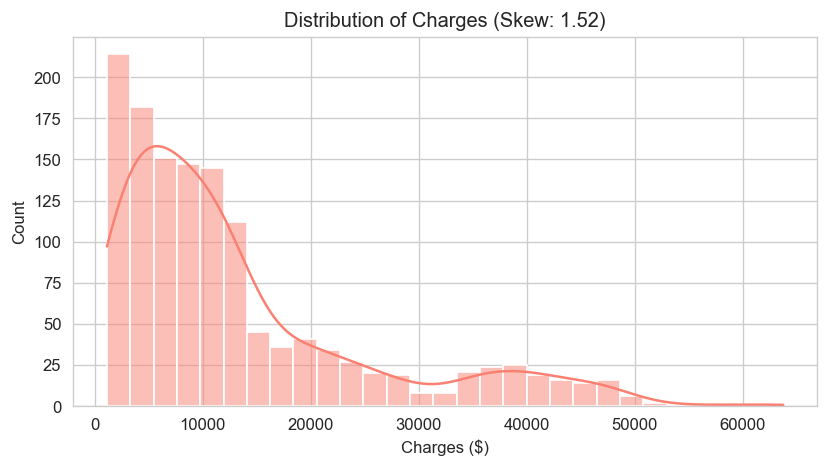

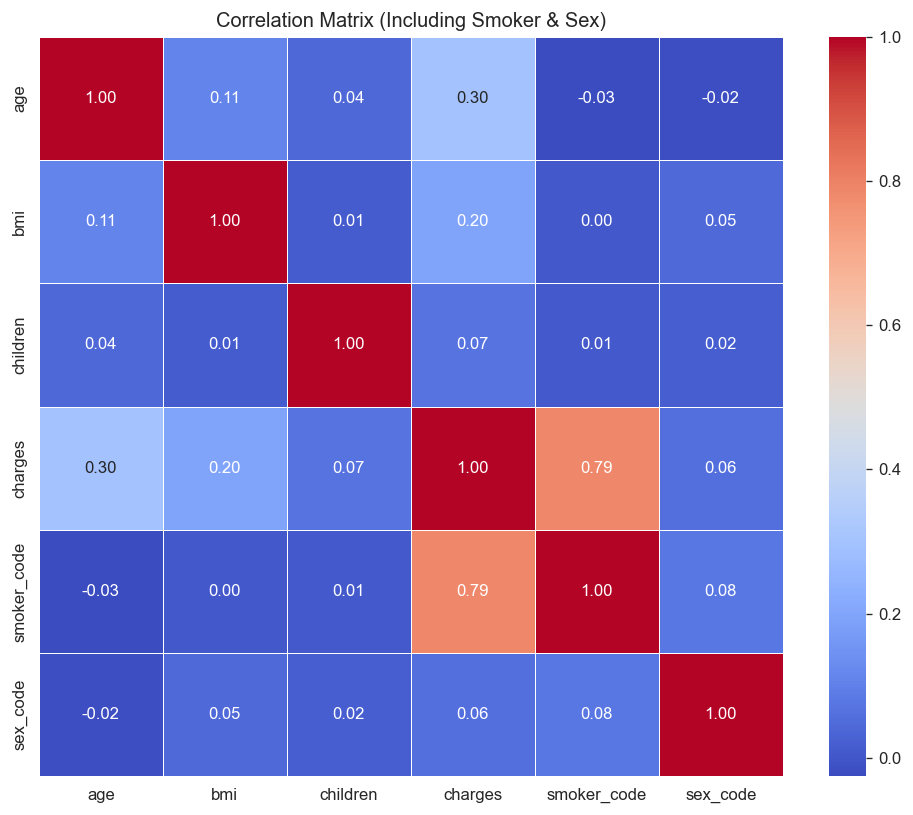

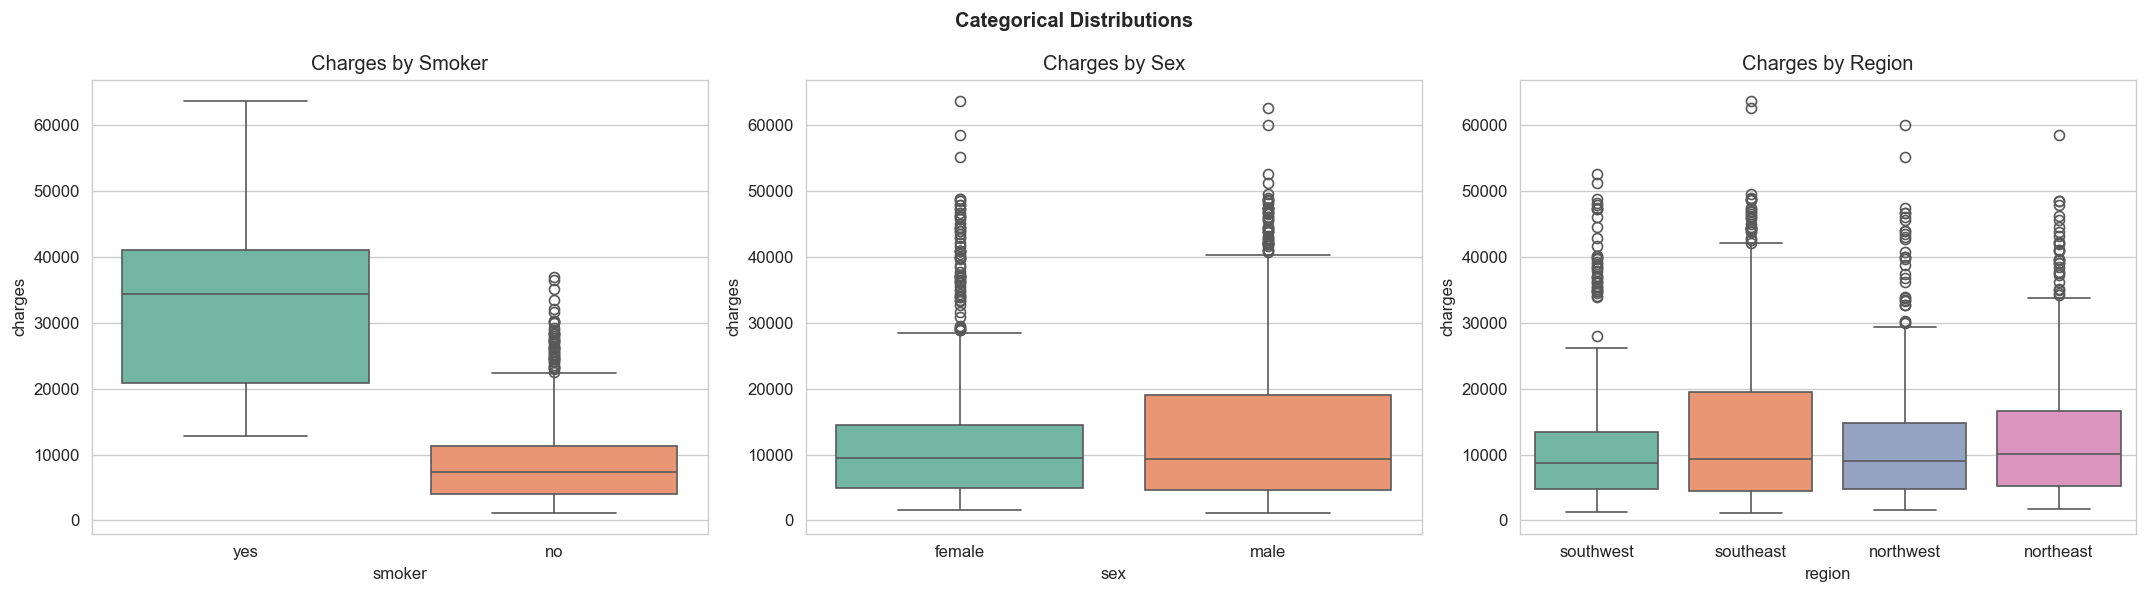

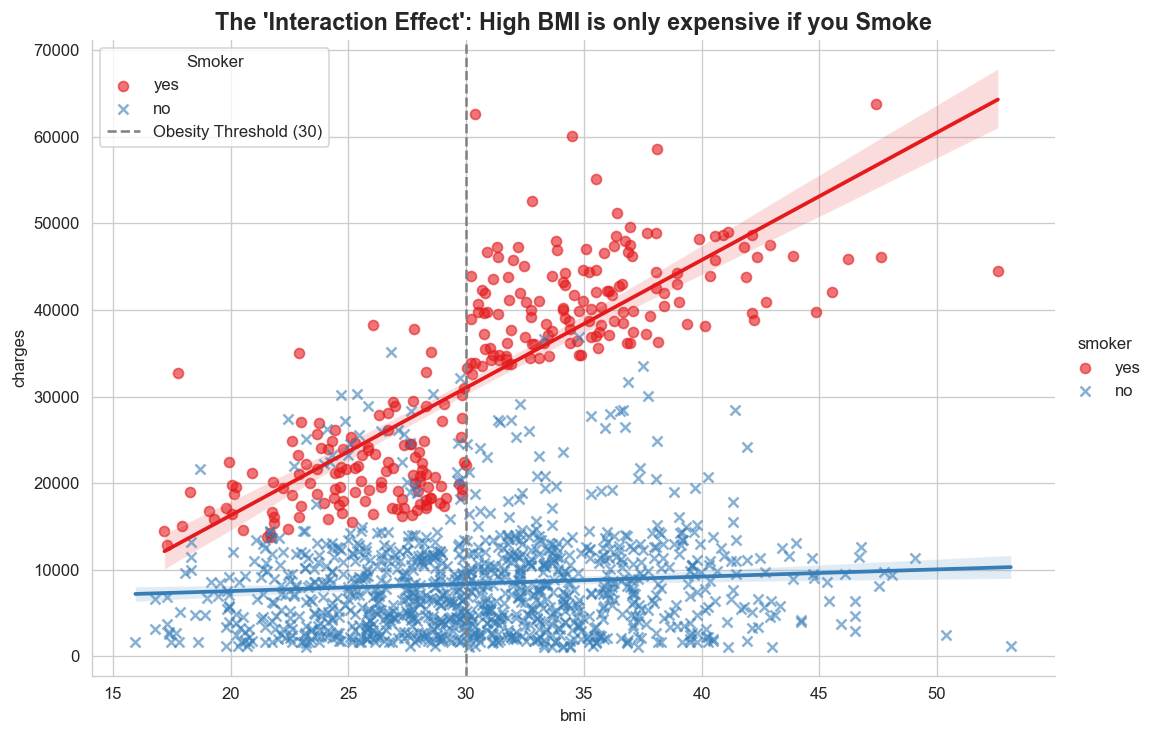

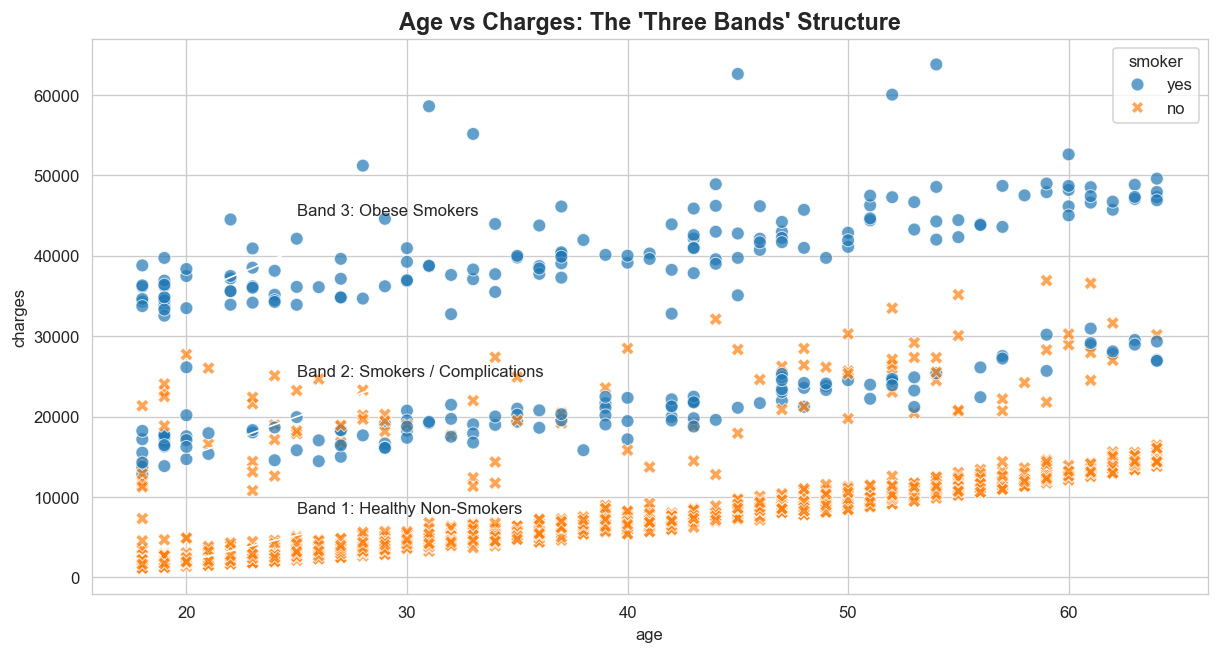

In [1]:
# ==============================================================================
# PHASE 1: PURE EDA (Initial Data Exploration)
# ==============================================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

# 1. Setup
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 120

# 2. Load Data (Bulletproof)
if os.path.exists("insurance.csv"):
    df = pd.read_csv("insurance.csv")
    print("Loaded 'insurance.csv' locally.")
elif os.path.exists(r"C:\Users\yulda\Desktop\insurance.csv"):
    df = pd.read_csv(r"C:\Users\yulda\Desktop\insurance.csv")
    print("Loaded from absolute path.")
else:
    url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
    print(f"Downloading from {url}...")
    df = pd.read_csv(url)

# 3. Basic Health Check
print("\n--- Data Info ---")
print(df.info())
print(df.head(10))

print("\n--- Missing Values ---")
print(df.isnull().sum())

print(f"\n--- Duplicates: {df.duplicated().sum()} (Removing them...) ---")
df.drop_duplicates(inplace=True)

# 4. Statistical Summary (Numerical)
print("\n--- Numerical Statistics ---")
print(df.describe())

# 5. Visuals: Univariate & Bivariate (Standard)

# A. Target Distribution 
plt.figure(figsize=(8, 4))
sns.histplot(df['charges'], kde=True, color='salmon')
plt.title(f"Distribution of Charges (Skew: {df['charges'].skew():.2f})")
plt.xlabel("Charges ($)")
plt.show()

# B. Correlation Heatmap 
plt.figure(figsize=(10, 8))

# Creating a temporary copy so we don't mess up the main dataframe
corr_df = df.copy()

# Encode binary categories to force them into the correlation matrix
# This reveals that 'smoker' is the #1 driver of cost (approx 0.78 correlation)
corr_df['smoker_code'] = corr_df['smoker'].map({'yes': 1, 'no': 0})
corr_df['sex_code'] = corr_df['sex'].map({'male': 1, 'female': 0})

# Select numeric columns (now including our encoded ones)
numeric_df = corr_df.select_dtypes(include=[np.number])

# Plot
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Including Smoker & Sex)")
plt.show()

# C. Categorical Features vs Target (Boxplots)
# Simple check: Do smokers/sex/regions cost more?
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='smoker', y='charges', data=df, ax=ax[0], palette='Set2', hue='smoker', legend=False)
ax[0].set_title("Charges by Smoker")

sns.boxplot(x='sex', y='charges', data=df, ax=ax[1], palette='Set2', hue='sex', legend=False)
ax[1].set_title("Charges by Sex")

sns.boxplot(x='region', y='charges', data=df, ax=ax[2], palette='Set2', hue='region', legend=False)
ax[2].set_title("Charges by Region")

plt.suptitle("Categorical Distributions", weight='bold')
plt.tight_layout()
plt.show()

# --- VISUAL 2: The "Money Plot" (Interaction) -------------------------------
# Why this matters: This proves that BMI behaves differently for Smokers.
# This single plot justifies the 'bmi_smoker_interaction' feature.

sns.lmplot(x="bmi", y="charges", hue="smoker", data=df, 
           palette="Set1", height=6, aspect=1.5, markers=["o", "x"],
           scatter_kws={'alpha': 0.6})
plt.title("The 'Interaction Effect': High BMI is only expensive if you Smoke", fontsize=14, weight='bold')
plt.axvline(30, color='gray', linestyle='--', label="Obesity Threshold (30)")
plt.legend(loc='upper left', title="Smoker")
plt.show()


# --- VISUAL 3: The "Three Bands" of Cost (Age Dynamics) -----------------------
# Why this matters: Reveals distinct pricing tiers in the data.
plt.figure(figsize=(12, 6))
sns.scatterplot(x="age", y="charges", hue="smoker", style="smoker", data=df, alpha=0.7, s=60)
plt.title("Age vs Charges: The 'Three Bands' Structure", fontsize=14, weight='bold')
plt.annotate('Band 1: Healthy Non-Smokers', xy=(20, 2000), xytext=(25, 8000), 
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate('Band 2: Smokers / Complications', xy=(20, 15000), xytext=(25, 25000), 
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate('Band 3: Obese Smokers', xy=(20, 35000), xytext=(25, 45000), 
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.show()




In [2]:
# ==============================================================================
# PHASE 2 & 3: PREPROCESSING & MODEL TUNING
# ==============================================================================

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import pandas as pd
import numpy as np
import time

# --- 1. Feature Engineering (Applying EDA insights) ---------------------------
# We re-load briefly just to be safe, or use existing df
if 'df' not in locals():
    # Fallback loader
    import os
    if os.path.exists("insurance.csv"): df = pd.read_csv("insurance.csv")
    else: df = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

# A. Create the Interaction Term (Crucial for original logic)
df['bmi_smoker'] = df['bmi'] * df['smoker'].map({'yes': 1, 'no': 0})

# B. Prepare X and y
X = df.drop('charges', axis=1)
y = np.log1p(df['charges']) # Log-transform target to fix skewness

# C. Stratified Split (Protects against imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=df['smoker']
)

print(f"Data Split: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples.")

# --- 2. The Pipelines --------------------
numeric_features = ['age', 'bmi', 'children', 'bmi_smoker']
categorical_features = ['sex', 'smoker', 'region']

# Pipeline for Numbers
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for Categories
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first')) # drop='first' avoids collinearity
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features)
])

# --- 3. Model Training & Hyperparameter Tuning --------------------------------

results = {}

# A. Ridge Regression (Better than simple Linear Regression)
print("\ Tuning Ridge Regression...")
pipe_ridge = Pipeline([('prep', preprocessor), ('model', Ridge())])
grid_ridge = {'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

search_ridge = GridSearchCV(pipe_ridge, grid_ridge, cv=5, scoring='neg_root_mean_squared_error')
search_ridge.fit(X_train, y_train)
results['Ridge'] = search_ridge.best_estimator_
print(f"   Best Alpha: {search_ridge.best_params_['model__alpha']}")

# B. Random Forest (The Ensemble Heavyweight)
print("\ Tuning Random Forest .")
pipe_rf = Pipeline([('prep', preprocessor), ('model', RandomForestRegressor(random_state=42))])
grid_rf = {
    'model__n_estimators': [100, 200],      # Trees
    'model__max_depth': [5, 10, None],      # Depth
    'model__min_samples_leaf': [1, 4]       # Overfitting control
}

search_rf = GridSearchCV(pipe_rf, grid_rf, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
search_rf.fit(X_train, y_train)
results['Random Forest'] = search_rf.best_estimator_
print(f"   Best Params: {search_rf.best_params_}")

# C. XGBoost (The "Kaggle Winner")
print("\ Tuning XGBoost...")
pipe_xgb = Pipeline([('prep', preprocessor), ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))])
grid_xgb = {
    'model__n_estimators': [100, 300],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5]
}

search_xgb = GridSearchCV(pipe_xgb, grid_xgb, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
search_xgb.fit(X_train, y_train)
results['XGBoost'] = search_xgb.best_estimator_
print(f"   Best Params: {search_xgb.best_params_}")


# --- 4. Preliminary Evaluation (RMSE on Test Set) -----------------------------
print("\n" + "="*40)
print("INTERMEDIATE LEADERBOARD (Log Scale RMSE)")
print("="*40)

for name, model in results.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name:15} | RMSE: {rmse:.4f} | R2: {r2:.4f}")


Data Split: 935 training samples, 402 test samples.
\ Tuning Ridge Regression...
   Best Alpha: 1.0
\ Tuning Random Forest .
   Best Params: {'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__n_estimators': 200}
\ Tuning XGBoost...
   Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}

INTERMEDIATE LEADERBOARD (Log Scale RMSE)
Ridge           | RMSE: 0.3998 | R2: 0.8066
Random Forest   | RMSE: 0.3269 | R2: 0.8707
XGBoost         | RMSE: 0.3279 | R2: 0.8699



 STARTING FINAL EVALUATION...

 FINAL LEADERBOARD 
        Model    RMSE ($)     MAE ($)  R2 Score
Random Forest 4323.125409 1995.789694  0.868483
      XGBoost 4394.537962 2008.017947  0.864102
        Ridge 7988.722417 3837.563696  0.550903

 Analysis will focus on the winner: Random Forest


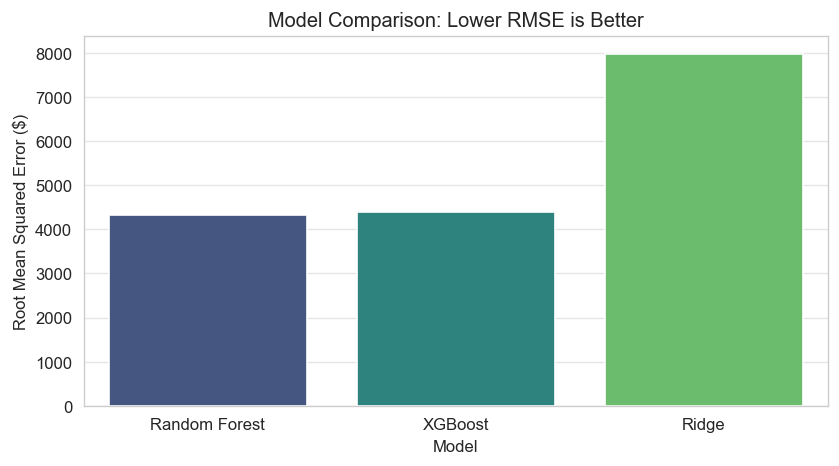

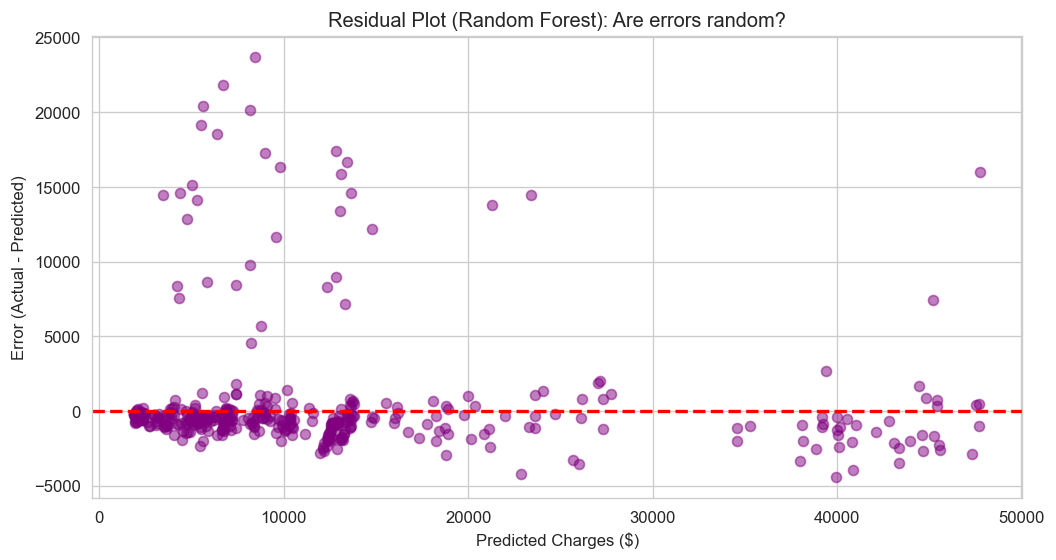

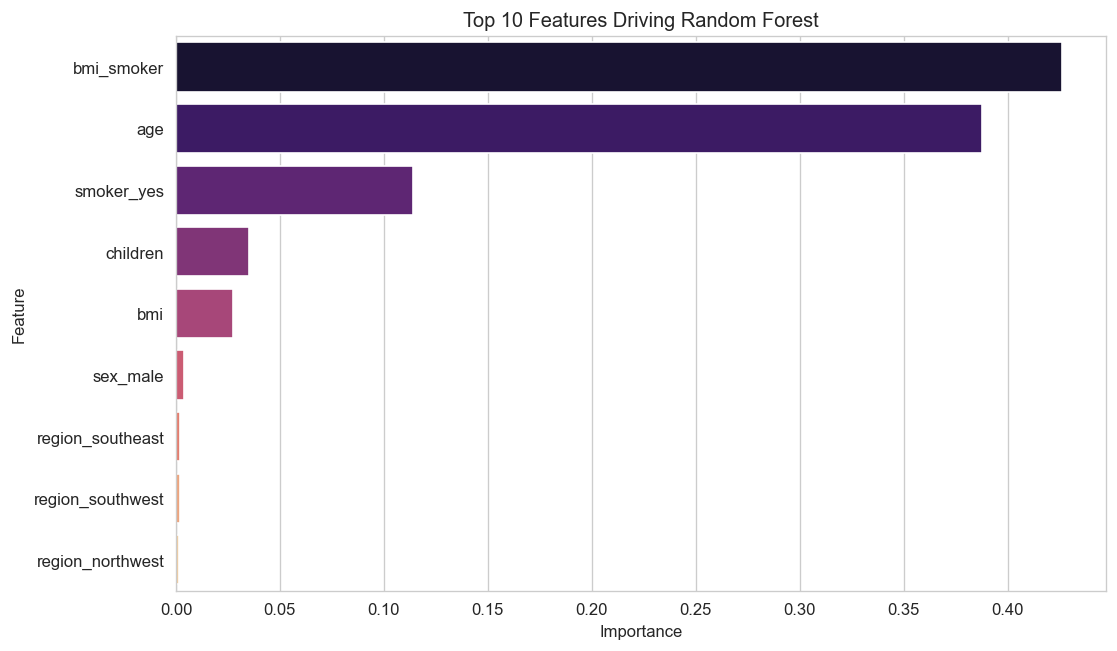


generating 'Lecture-Style' Visuals for Proof of Experimentation...


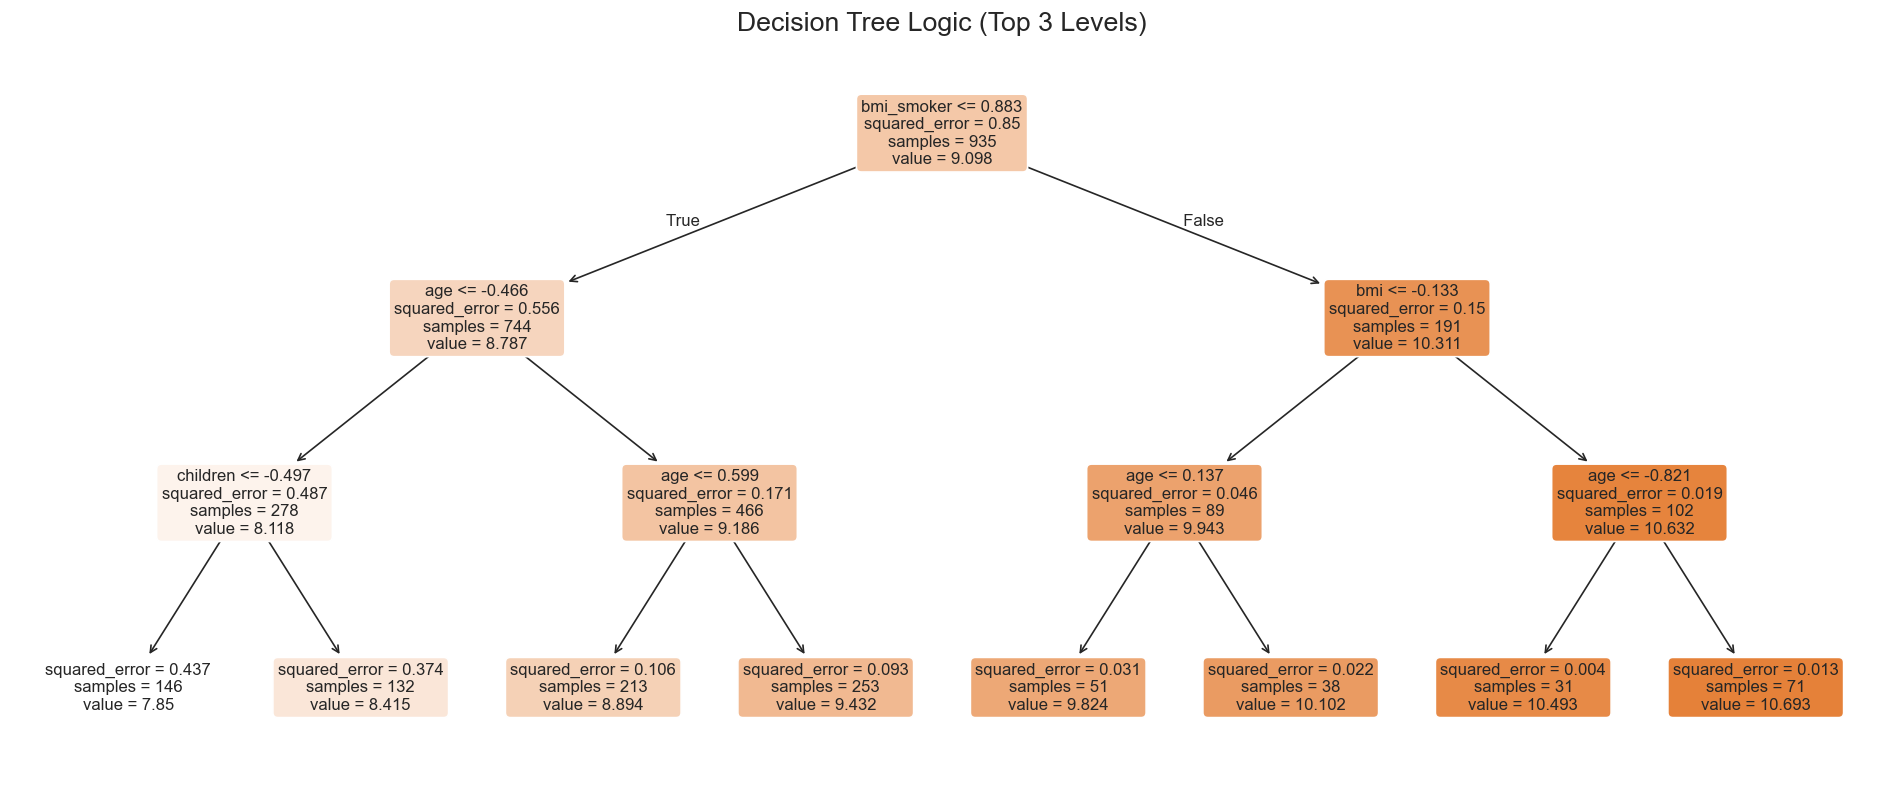

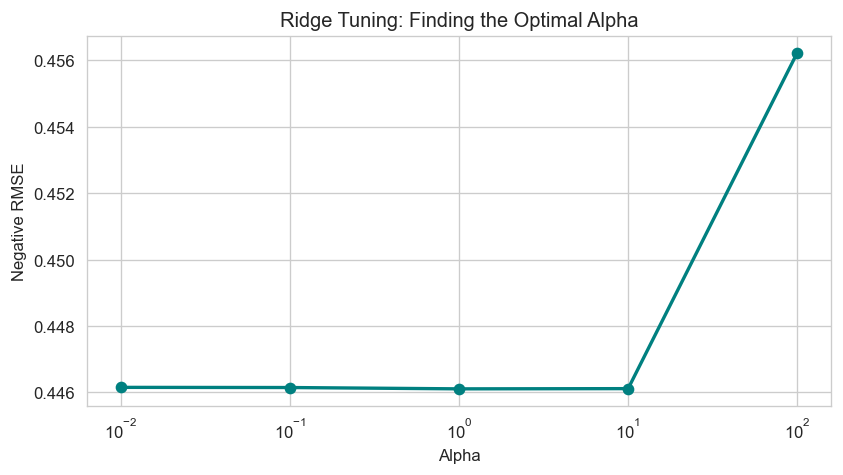

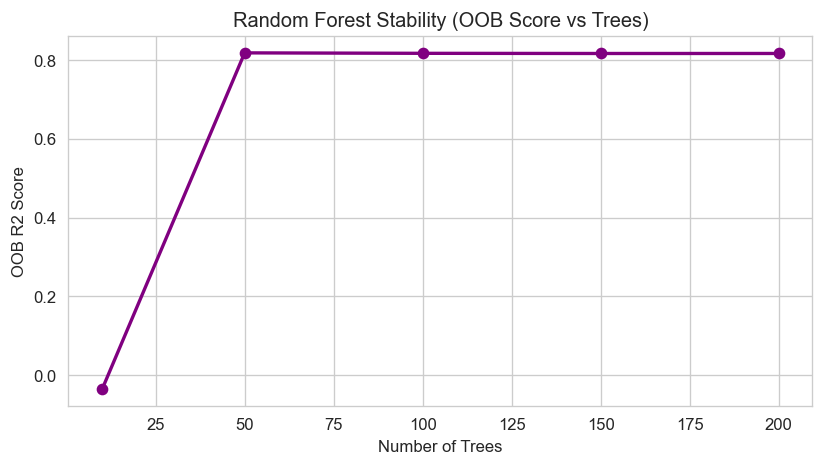

In [3]:
# ==============================================================================
# PHASE 4: FINAL EVALUATION & VISUALS (COMPLETE MERGED VERSION)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import plot_tree, DecisionTreeRegressor

print("\n STARTING FINAL EVALUATION...\n")

# ------------------------------------------------------------------------------
# PART A: THE LEADERBOARD (Who Won?)
# ------------------------------------------------------------------------------
leaderboard = []

for name, model in results.items():
    # Predict on Test Set (Log Scale)
    y_pred_log = model.predict(X_test)
    
    # Convert back to Real Dollars ($)
    y_true = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)
    
    # Calculate Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    leaderboard.append({'Model': name, 'RMSE ($)': rmse, 'MAE ($)': mae, 'R2 Score': r2})

df_results = pd.DataFrame(leaderboard).sort_values(by='RMSE ($)', ascending=True)

print(" FINAL LEADERBOARD ")
print(df_results.to_string(index=False))

# Identify the winner for specific plots
best_model_name = df_results.iloc[0]['Model']
best_model = results[best_model_name]
print(f"\n Analysis will focus on the winner: {best_model_name}")

# ------------------------------------------------------------------------------
# PART B: PERFORMANCE VISUALS (Accuracy & Errors)
# ------------------------------------------------------------------------------

# VISUAL 1: Model Comparison (Bar Chart)
plt.figure(figsize=(8, 4))
sns.barplot(x='Model', y='RMSE ($)', data=df_results, palette='viridis')
plt.title("Model Comparison: Lower RMSE is Better")
plt.ylabel("Root Mean Squared Error ($)")
plt.grid(True, axis='y', alpha=0.5)
plt.show()

# VISUAL 2: Error Analysis (Residual Plot of Winner)
# Requirement: "Analyze incorrect predictions"
y_pred_best_log = best_model.predict(X_test)
y_true = np.expm1(y_test)
y_pred = np.expm1(y_pred_best_log)
residuals = y_true - y_pred

plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicted Charges ($)")
plt.ylabel("Error (Actual - Predicted)")
plt.title(f"Residual Plot ({best_model_name}): Are errors random?")
plt.show()

# VISUAL 3: Feature Importance (Logic Check)
# Requirement: "Model Interpretation"
if best_model_name in ['Random Forest', 'XGBoost']:
    plt.figure(figsize=(10, 6))
    
    # Extract feature names
    ohe_cols = best_model.named_steps['prep'].named_transformers_['cat']['ohe'].get_feature_names_out(categorical_features)
    all_feats = numeric_features + list(ohe_cols)
    importances = best_model.named_steps['model'].feature_importances_
    
    # Plot Top 10
    feat_df = pd.DataFrame({'Feature': all_feats, 'Importance': importances})
    feat_df = feat_df.sort_values(by='Importance', ascending=False).head(10)
    
    sns.barplot(x='Importance', y='Feature', data=feat_df, palette='magma')
    plt.title(f"Top 10 Features Driving {best_model_name}")
    plt.show()

# ------------------------------------------------------------------------------
# PART C: PROCESS VISUALS (Teacher Requirements / Lecture Style)
# ------------------------------------------------------------------------------
print("\ngenerating 'Lecture-Style' Visuals for Proof of Experimentation...")

# VISUAL 4: Decision Tree Diagram
# Shows you understand the tree structure (Slide 40+)
viz_pipe = Pipeline([('prep', preprocessor), ('model', DecisionTreeRegressor(max_depth=3, random_state=42))])
viz_pipe.fit(X_train, y_train)

plt.figure(figsize=(20, 8))
plot_tree(viz_pipe.named_steps['model'], 
          feature_names=numeric_features + list(preprocessor.named_transformers_['cat']['ohe'].get_feature_names_out(categorical_features)),
          filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Logic (Top 3 Levels)", fontsize=16)
plt.show()

# VISUAL 5: Ridge Tuning Curve
# Requirement: "Show how you found Alpha" (Slide 57)
if 'search_ridge' in locals():
    results_ridge = pd.DataFrame(search_ridge.cv_results_)
    plt.figure(figsize=(8, 4))
    plt.plot(results_ridge['param_model__alpha'].astype(float), -results_ridge['mean_test_score'], marker='o', color='teal', linewidth=2)
    plt.xscale('log') 
    plt.title("Ridge Tuning: Finding the Optimal Alpha")
    plt.xlabel("Alpha")
    plt.ylabel("Negative RMSE")
    plt.grid(True)
    plt.show()

# VISUAL 6: Random Forest Stability (OOB)
# Requirement: "Show stability/bagging effect" (Slide 21 of Bagging)
n_trees_range = [10, 50, 100, 150, 200]
oob_scores = []
for n in n_trees_range:
    rf_viz = RandomForestRegressor(n_estimators=n, oob_score=True, random_state=42, n_jobs=-1, max_depth=5)
    pipe_viz = Pipeline([('prep', preprocessor), ('model', rf_viz)])
    pipe_viz.fit(X_train, y_train)
    oob_scores.append(pipe_viz.named_steps['model'].oob_score_)

plt.figure(figsize=(8, 4))
plt.plot(n_trees_range, oob_scores, marker='o', color='purple', linewidth=2)
plt.title("Random Forest Stability (OOB Score vs Trees)")
plt.xlabel("Number of Trees")
plt.ylabel("OOB R2 Score")
plt.grid(True)
plt.show()


In [4]:
train_metrics = []

for name, model in results.items():
    # Predict on TRAIN (log scale)
    y_train_pred_log = model.predict(X_train)
    
    # Convert back to original scale
    y_train_true = np.expm1(y_train)
    y_train_pred = np.expm1(y_train_pred_log)
    
    train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    train_r2 = r2_score(y_train_true, y_train_pred)
    
    train_metrics.append({
        "Model": name,
        "Train RMSE ($)": train_rmse,
        "Train R2": train_r2
    })

df_train = pd.DataFrame(train_metrics)
df_train


,Model,Train RMSE ($),Train R2
0,Ridge,8755.659467,0.483624
1,Random Forest,4298.986672,0.875514
2,XGBoost,4339.316075,0.873167


In [5]:
df_compare = df_train.merge(
    df_results.rename(columns={
        "RMSE ($)": "Test RMSE ($)",
        "R2 Score": "Test R2"
    })[["Model", "Test RMSE ($)", "Test R2"]],
    on="Model"
)

df_compare


,Model,Train RMSE ($),Train R2,Test RMSE ($),Test R2
0,Ridge,8755.659467,0.483624,7988.722417,0.550903
1,Random Forest,4298.986672,0.875514,4323.125409,0.868483
2,XGBoost,4339.316075,0.873167,4394.537962,0.864102
